# PostHoc Analysis

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

sns.set_theme(style="whitegrid")

In [2]:
#change directory for your path
os.chdir('E:\\OneDrive\\Documents\\GitHub\\eHealthEquity\\Research\\Data Source')

In [3]:
df = pd.read_csv('final_merge.csv')

target = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
features = [
    'pct_dg_bb_int',
    #'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    #'brfss_csmoking_ageadjprv',
    #'brfss_depression_ageadjprv',
    #'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    'pct_ed_hs',
    #'pct_ed_sc',
    'pct_ed_asc',
    #'pct_ed_b',
    #'pct_ed_gr',
    'pct_age_gte65',
    #'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    #'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    #'pct_occ_svc',
    #'pct_occ_sales',
    #'pct_occ_nat_res',
    #'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    #'pct_tp_veh_1',
    #'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    #'ruca_metro',
    #'ruca_micro',
    #'ruca_small_town',
    'ruca_rural'
]
geo = [
    'state',
    'county'
]
df = df[geo + target + features]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   state                     3076 non-null   object 
 1   county                    3076 non-null   object 
 2   brfss_diabetes_ageadjprv  3076 non-null   float64
 3   pct_dg_bb_int             3076 non-null   float64
 4   brfss_checkup_ageadjprv   3076 non-null   float64
 5   brfss_mhlth_ageadjprv     3076 non-null   float64
 6   brfss_obesity_ageadjprv   3076 non-null   float64
 7   pct_ed_lt9                3076 non-null   float64
 8   pct_ed_9_12               3076 non-null   float64
 9   pct_ed_hs                 3076 non-null   float64
 10  pct_ed_asc                3076 non-null   float64
 11  pct_age_gte65             3076 non-null   float64
 12  pct_race_black            3076 non-null   float64
 13  pct_race_aian             3076 non-null   float64
 14  pct_race

# Predictive Power

In [18]:
X = df[features]
y = df[target]
y = np.array(y).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=418)

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
print('Linear Regression')
print('Size of training set: ', X_train.shape[0])
print('Size of testing set: ', X_test.shape[0])

# Assess MAE, MSE, RMSE, and R^2 with cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=418)

print('')
mae = cross_val_score(lr, X_train, y_train, scoring=make_scorer(mean_absolute_error), cv=cv, n_jobs=-1)
print('MAE: %.3f (%.3f)' % (np.mean(mae), np.std(mae)))
mse = cross_val_score(lr, X_train, y_train, scoring=make_scorer(mean_squared_error), cv=cv, n_jobs=-1)
print('MSE: %.3f (%.3f)' % (np.mean(mse), np.std(mse)))
rmse = cross_val_score(lr, X_train, y_train, scoring=make_scorer(mean_squared_error, squared=False), cv=cv, n_jobs=-1)
print('RMSE: %.3f (%.3f)' % (np.mean(rmse), np.std(rmse)))
r2 = cross_val_score(lr, X_train, y_train, scoring=make_scorer(r2_score), cv=cv, n_jobs=-1)
print('R^2: %.3f (%.3f)' % (np.mean(r2), np.std(r2)))

# Assess MAE, MSE, RMSE, and R^2 with test set
y_pred = lr.predict(X_test)
print('')
print('Test set')
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)
mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % rmse)
r2 = r2_score(y_test, y_pred)
print('R^2: %.3f' % r2)


Linear Regression
Size of training set:  2307
Size of testing set:  769

MAE: 0.457 (0.024)
MSE: 0.383 (0.049)
RMSE: 0.617 (0.040)
R^2: 0.925 (0.011)

Test set
MAE: 0.479
MSE: 0.403
RMSE: 0.634
R^2: 0.918


# Geographic Analysis
Organized by larger regions defined by the US Census Bureau. The regions are Northeast, Midwest, South, and West.

In [5]:
regions = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania'],
    'Midwest': ['Indiana', 'Illinois', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
    'South': ['Delaware', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
}

df['region'] = df['state'].apply(lambda x: [k for k, v in regions.items() if x in v][0])

unmapped = df[~df['region'].isin(regions.keys())]
unmapped['state'].unique()

array([], dtype=object)

In [6]:
def regression_by_region(region_name, data, predictors, target):
    region_data = data[data['region'] == region_name]
    region_target = region_data[target]
    region_features = region_data[predictors]
    region_features = sm.add_constant(region_features)
    region_model = sm.OLS(region_target, region_features).fit()
    bb_int_coef = region_model.params['pct_dg_bb_int']

    return region_model, bb_int_coef

region_coef = {}

for region in df['region'].unique():
    region_model, bb_int_coef = regression_by_region(region, df, features, target)
    region_coef[region] = bb_int_coef

region_coef

{'West': -0.01465962307805669,
 'South': -0.007419407999862132,
 'Northeast': 0.0029414615561734027,
 'Midwest': -0.003405581268797068}

In [7]:
def regression_by_state(state_name, data, predictors, target):
    state_data = data[data['state'] == state_name]
    state_target = state_data[target]
    state_features = state_data[predictors]
    state_features = sm.add_constant(state_features)
    state_model = sm.OLS(state_target, state_features).fit()
    bb_int_coef = state_model.params['pct_dg_bb_int']

    return state_model, bb_int_coef

state_coef = {}

for state in df['state'].unique():
    state_model, bb_int_coef = regression_by_state(state, df, features, target)
    state_coef[state] = bb_int_coef

state_coef


{'Alaska': 0.002418833157034561,
 'Alabama': -0.011859505650560126,
 'Arkansas': -0.001602191875789416,
 'Arizona': -0.04109473677280065,
 'California': -0.026781047148227072,
 'Colorado': 0.014080732029016649,
 'Connecticut': -0.03480731793269787,
 'District of Columbia': 0.03732039863859621,
 'Delaware': 0.02453769952530593,
 'Georgia': 0.0022804718509326603,
 'Hawaii': -0.008577077273760385,
 'Iowa': 0.00023396260636904254,
 'Idaho': -0.011233477482304632,
 'Illinois': -0.004046027504326224,
 'Indiana': 0.0061792781071618175,
 'Kansas': 0.0057254730271680335,
 'Kentucky': -0.010493287064576182,
 'Louisiana': -0.022633059396420463,
 'Massachusetts': -0.0857531654323902,
 'Maryland': 0.12271305710487135,
 'Maine': -0.03367449361479047,
 'Michigan': -0.010631765316182894,
 'Minnesota': -0.012732065997168772,
 'Missouri': 0.0179454462350295,
 'Mississippi': 0.007068144912380725,
 'Montana': 0.005063796164559126,
 'North Carolina': 0.004724982243426767,
 'North Dakota': -0.01033203331096

# Machine Learning : Alternative Models

In [19]:
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Multi-Layer Perceptron': MLPRegressor()
}


dt_params = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10]
}

rf_params = {
    'n_estimators': [50, 150],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 6, 10]
}

gb_params = {
    'n_estimators': [50, 150],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 6, 10],
    'learning_rate': [0.01, 0.1]
}

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

mlp_params = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive']
}

params = {
    'Decision Tree': dt_params,
    'Random Forest': rf_params,
    'Gradient Boosting': gb_params,
    'K-Nearest Neighbors': knn_params,
    'Multi-Layer Perceptron': mlp_params
}


In [21]:
for model_name, model in models.items():
    print('Model:', model_name)
    grid_search = GridSearchCV(model, params[model_name], cv=15, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
    grid_search.fit(X, y)
    print('Best Parameters:', grid_search.best_params_)
    print('Best Score:', -grid_search.best_score_)
    print()

Model: Decision Tree
Fitting 15 folds for each of 810 candidates, totalling 12150 fits
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 6}
Best Score: 0.7051516349349695

Model: Random Forest
Fitting 15 folds for each of 72 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best Score: 0.5525369071681799

Model: Gradient Boosting
Fitting 15 folds for each of 144 candidates, totalling 2160 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.513922524495836

Model: K-Nearest Neighbors
Fitting 15 folds for each of 12 candidates, totalling 180 fits


c:\ProgramData\miniconda3\envs\ds_mf\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: nan

Model: Multi-Layer Perceptron
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best Score: 0.4962665624437043



Model: Decision Tree
Fitting 15 folds for each of 810 candidates, totalling 12150 fits
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 6}
Best Score: 0.7051516349349695

Model: Random Forest
Fitting 15 folds for each of 72 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best Score: 0.5525369071681799

Model: Gradient Boosting
Fitting 15 folds for each of 144 candidates, totalling 2160 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.513922524495836

Model: K-Nearest Neighbors
Fitting 15 folds for each of 12 candidates, totalling 180 fits
c:\ProgramData\miniconda3\envs\ds_mf\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: nan

Model: Multi-Layer Perceptron
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best Score: 0.4962665624437043

In [23]:
from sklearn.model_selection import RandomizedSearchCV

for model_name, model in models.items():
    print('Model:', model_name)
    random_search = RandomizedSearchCV(model, params[model_name], cv=15, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
    random_search.fit(X, y)
    print('Best Parameters:', random_search.best_params_)
    print('Best Score:', -random_search.best_score_)
    print()

Model: Decision Tree
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 9, 'max_depth': 9}
Best Score: 0.7060421003705684

Model: Random Forest
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best Score: 0.5515972712496034

Model: Gradient Boosting
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 5, 'learning_rate': 0.1}
Best Score: 0.5335425140381909

Model: K-Nearest Neighbors
Fitting 15 folds for each of 10 candidates, totalling 150 fits


c:\ProgramData\miniconda3\envs\ds_mf\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 5}
Best Score: nan

Model: Multi-Layer Perceptron
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (40,), 'activation': 'relu'}
Best Score: 0.49043231597345843



Model: Decision Tree
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 9, 'max_depth': 9}
Best Score: 0.7060421003705684

Model: Random Forest
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best Score: 0.5515972712496034

Model: Gradient Boosting
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 5, 'learning_rate': 0.1}
Best Score: 0.5335425140381909

Model: K-Nearest Neighbors
Fitting 15 folds for each of 10 candidates, totalling 150 fits
c:\ProgramData\miniconda3\envs\ds_mf\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
Best Parameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 5}
Best Score: nan

Model: Multi-Layer Perceptron
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (40,), 'activation': 'relu'}
Best Score: 0.49043231597345843


In [24]:
#additional MLP parameters 
mlp_params = {
    'hidden_layer_sizes': [(10,80,30,5), (40,20,10), (50,), (40,), (50,10,4)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'early_stopping': [True]
}

mlp = MLPRegressor()

mlp_random_search = RandomizedSearchCV(mlp, mlp_params, cv=15, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
mlp_random_search.fit(X, y)
print('Best Parameters:', mlp_random_search.best_params_)
print('Best Score:', -mlp_random_search.best_score_)
print()



Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (40, 20, 10), 'early_stopping': True, 'alpha': 0.1, 'activation': 'relu'}
Best Score: 0.49871462990045917



# MLP Predictive Capabilities and Cross-Fold Validation

In [28]:
#best model from hyperparameter tuning
model = MLPRegressor(activation='relu', hidden_layer_sizes=(40, 10, 4), learning_rate='adaptive', solver='adam', max_iter=1000, random_state=42, early_stopping=True, alpha=0.1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
cv_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
cv_rmse = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
cv_abs_error = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

print('R2 Mean:', cv_r2.mean())
print('RMSE Mean:', -cv_rmse.mean())
print('MAE Mean:', -cv_abs_error.mean())


R2 Mean: 0.9246651447604001
RMSE Mean: 0.616186049996793
MAE Mean: 0.4642448330397452


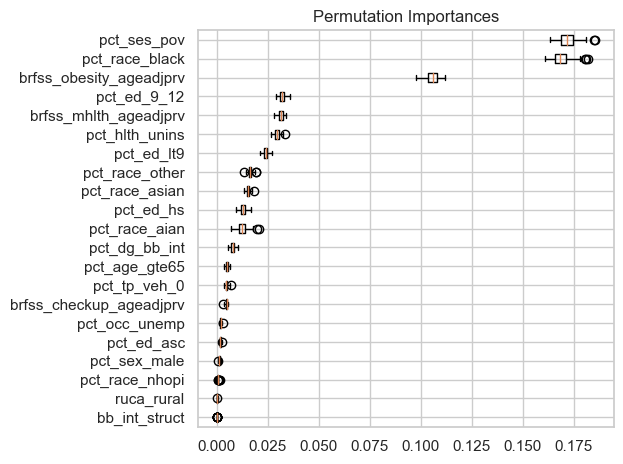

In [33]:
model.fit(X, y)
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X, y, n_repeats=100, random_state=42, n_jobs=-1)
sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()


# OLS Predictive Capabilities and Cross-fold validation

In [26]:
#linear model
model = LinearRegression(fit_intercept=True)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
cv_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
cv_rmse = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
cv_abs_error = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

print('R2 Mean:', cv_r2.mean())
print('RMSE Mean:', -cv_rmse.mean())
print('MAE Mean:', -cv_abs_error.mean())


R2 Mean: 0.9235430551313674
RMSE Mean: 0.6209565376836595
MAE Mean: 0.45993880372742546
